In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import clans_color_groups
import clans_parser
import pandas as pd

raw_clans_dir = Path("out/raw")
out_clans_dir = Path("out/color")
features_file = "Pla2g2_clans_features.tsv"

data = list()
for in_clans_file in sorted(
    raw_clans_dir.glob("*.clans"), key=lambda x: int(x.stem.split("_")[1])
):
    out_clans_file = out_clans_dir / in_clans_file.name
    if not out_clans_file.exists():
        clans_color_groups.main(
            features_file=features_file,
            input_clans_file=in_clans_file,
            output_clans_file=out_clans_file,
        )
        print(in_clans_file, out_clans_file)
    scores = clans_parser.main(out_clans_file)
    scores["p_val"] = int(out_clans_file.stem.split("_")[1])
    data.append(scores)

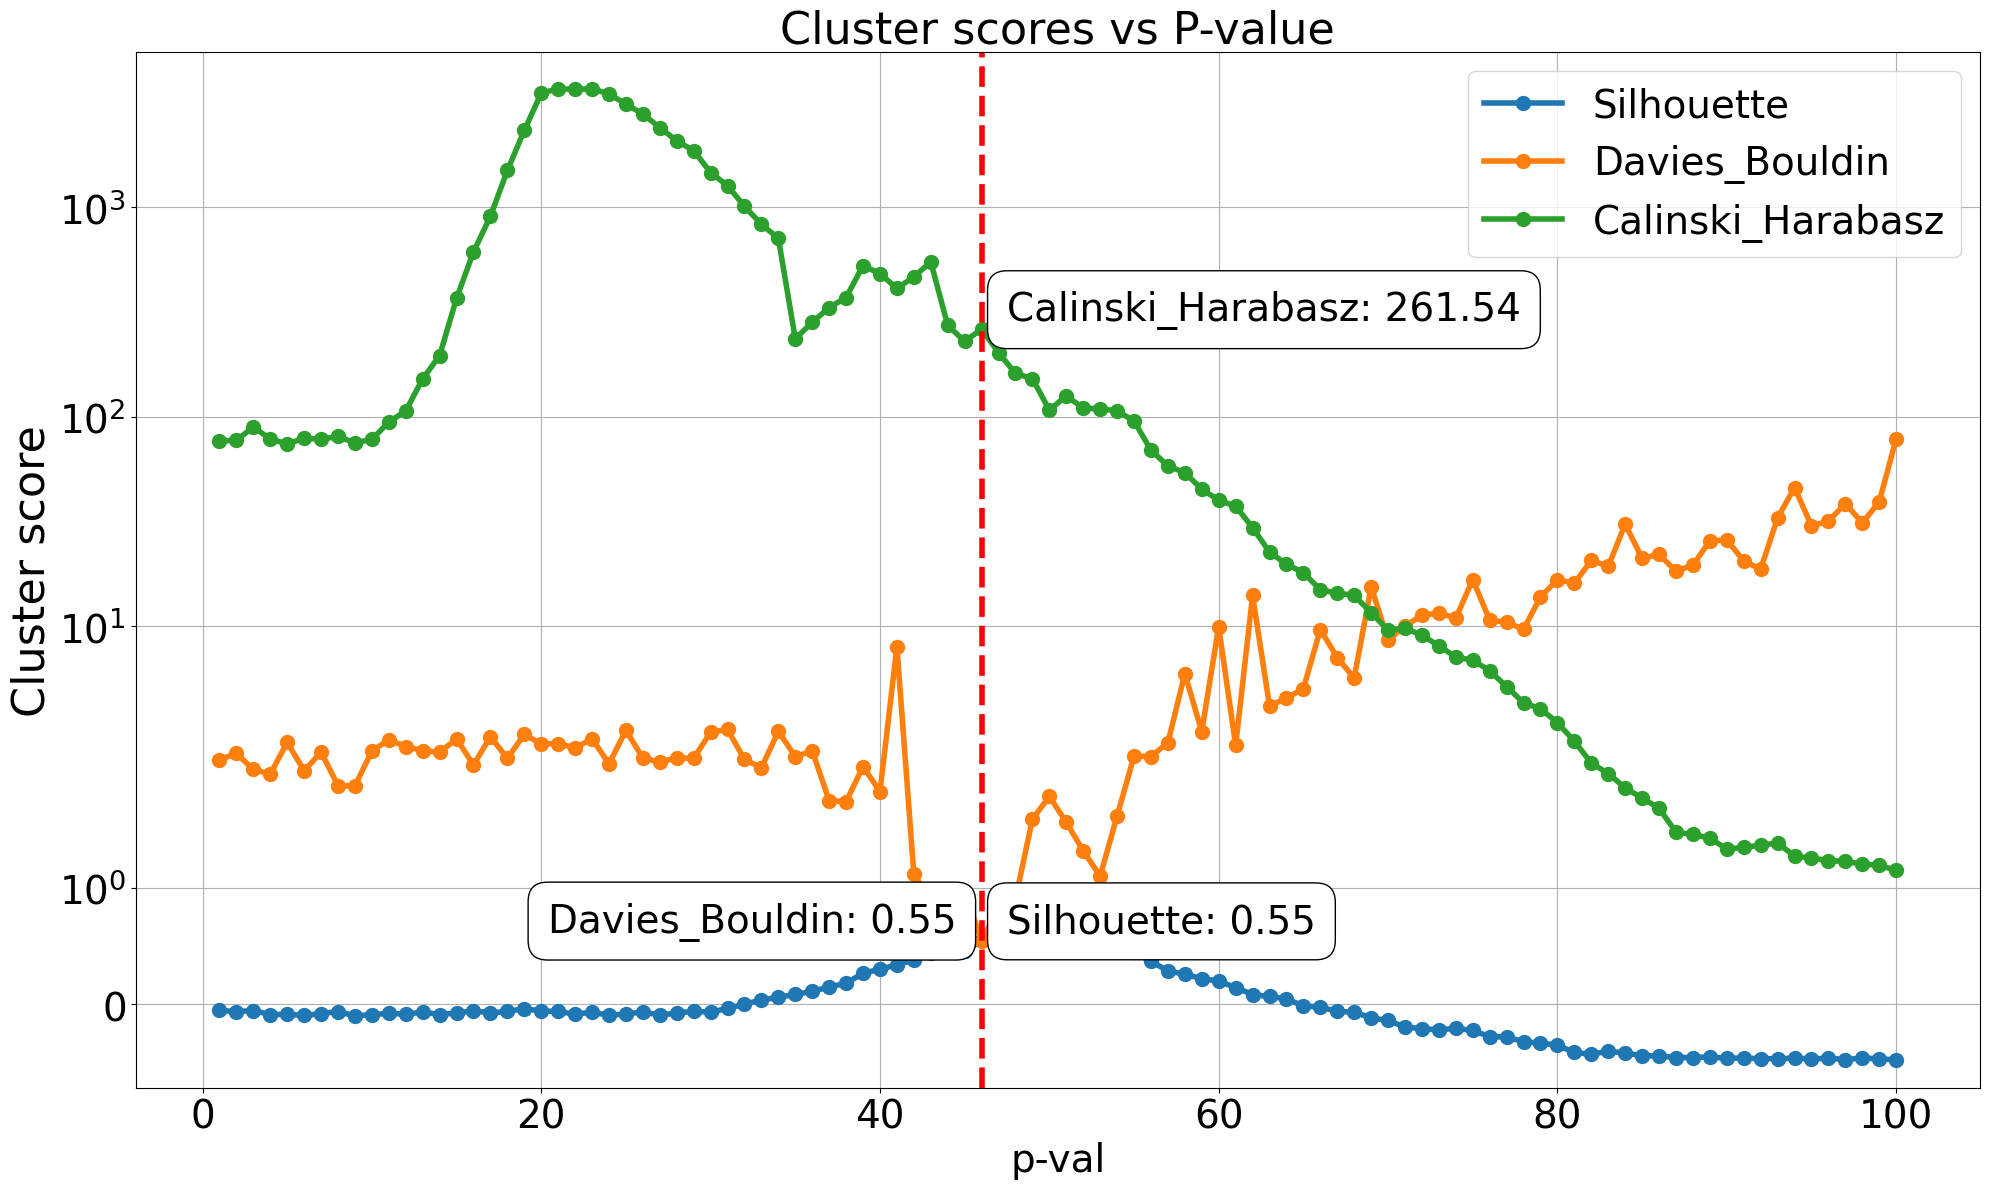

In [5]:
import matplotlib.pyplot as plt


def calculate_best_ranked_p_val(df):
    # Rank each score within its column
    df_ranks = df.drop(columns="p_val").rank()

    # Invert the rank for Davies_Bouldin score
    max_rank = df_ranks["Davies_Bouldin"].max()
    df_ranks["Davies_Bouldin"] = max_rank + 1 - df_ranks["Davies_Bouldin"]

    # Sum the ranks for each row
    df_ranks["aggregate_rank"] = df_ranks.sum(axis=1)

    # Determine the row with the lowest sum of ranks
    best_ranked_result = df_ranks[
        df_ranks["aggregate_rank"] == df_ranks["aggregate_rank"].max()
    ]

    # Add e_val to the result for reference
    best_ranked_result = best_ranked_result.copy()
    best_ranked_result["p_val"] = df["p_val"]

    return best_ranked_result["p_val"].values[0]


def plot_scores_vs_p_val(df, best_ranked_p_val, save_path, scale_factor=1):
    # Create plot
    plt.figure(figsize=(10 * scale_factor, 6 * scale_factor))
    linewidth = 2 * scale_factor
    markersize = 5 * scale_factor

    for column in df.columns:
        if column != "p_val":
            plt.plot(
                df["p_val"],
                df[column],
                label=column,
                marker="o",
                linewidth=linewidth,
                markersize=markersize,
            )

    # Draw a red vertical line for the best result
    plt.axvline(x=best_ranked_p_val, color="red", linestyle="--", linewidth=linewidth)

    # Annotate the best result with its scores above the respective dots
    cols = ["Silhouette", "Davies_Bouldin", "Calinski_Harabasz"]
    for col in cols:
        score = df[col][best_ranked_p_val - 1]
        y_pos = score
        x_pos = (
            best_ranked_p_val + 1.5
            if col != "Davies_Bouldin"
            else best_ranked_p_val - 1.5
        )
        horizontal_alignment = "left" if col != "Davies_Bouldin" else "right"
        plt.text(
            x_pos,
            y_pos,
            f"{col}: {score:.2f}",
            color="black",
            verticalalignment="bottom",
            horizontalalignment=horizontal_alignment,
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
            fontsize=14 * scale_factor,
        )

    # Adjust y-axis limits
    y_min = df.drop(columns="p_val").min().min()
    y_max = df.drop(columns="p_val").max().max()
    plt.ylim(y_min + y_min * 0.5, y_max + y_max * 0.5)

    # Set labels, title, legend, and other properties
    plt.xlabel("p-val", fontsize=14 * scale_factor)
    plt.ylabel("Cluster score", fontsize=16 * scale_factor)
    plt.title("Cluster scores vs P-value", fontsize=16 * scale_factor)
    legend = plt.legend(fontsize=14 * scale_factor)
    for legobj in legend.legend_handles:
        legobj.set_linewidth(linewidth)
        legobj.set_markersize(markersize)
    plt.xticks(fontsize=14 * scale_factor)
    plt.yticks(fontsize=14 * scale_factor)
    plt.grid(True)
    plt.yscale("symlog")
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight")
    plt.show()


df = pd.DataFrame(data)
# df.to_csv("Pla2g2_clans_data.csv", index=False)
best_p_val = calculate_best_ranked_p_val(df)
plot_scores_vs_p_val(
    df, best_p_val, scale_factor=2, save_path="out/img/cluster_score.png"
)